In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pylab import rcParams
import os
import gzip
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import trim_mean, iqr


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 20, 10

In [2]:
#csv file that has: timestamp, patient, day, cohort, step per sec, indoor prob
full_df = pd.read_csv('full_df.csv')

#we are just interested in outdoor envs
full_df = full_df[full_df['IndoorProb']!=100]

In [3]:
full_df.head()

Unnamed: 0  Patient Cohort   Day  StepPerSec   Timestamp  IndoorProb
29017       29017     1000     HA  Day1       0.875  1597302217           0
29018       29018     1000     HA  Day1       0.875  1597302218           0
29019       29019     1000     HA  Day1       0.875  1597302219           0
29020       29020     1000     HA  Day1       0.875  1597302220           0
29021       29021     1000     HA  Day1       0.875  1597302221           0

In [4]:
full_df.reset_index(inplace=True)

In [5]:
full_df['Patient'].unique()

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010,
       3011, 3013, 3014, 4002, 4005, 4011, 4013, 4019, 5000, 5003, 5005,
       5008, 5009, 5010, 5012, 5019], dtype=int64)

In [6]:
len(full_df['Patient'].unique())

71

<AxesSubplot:>

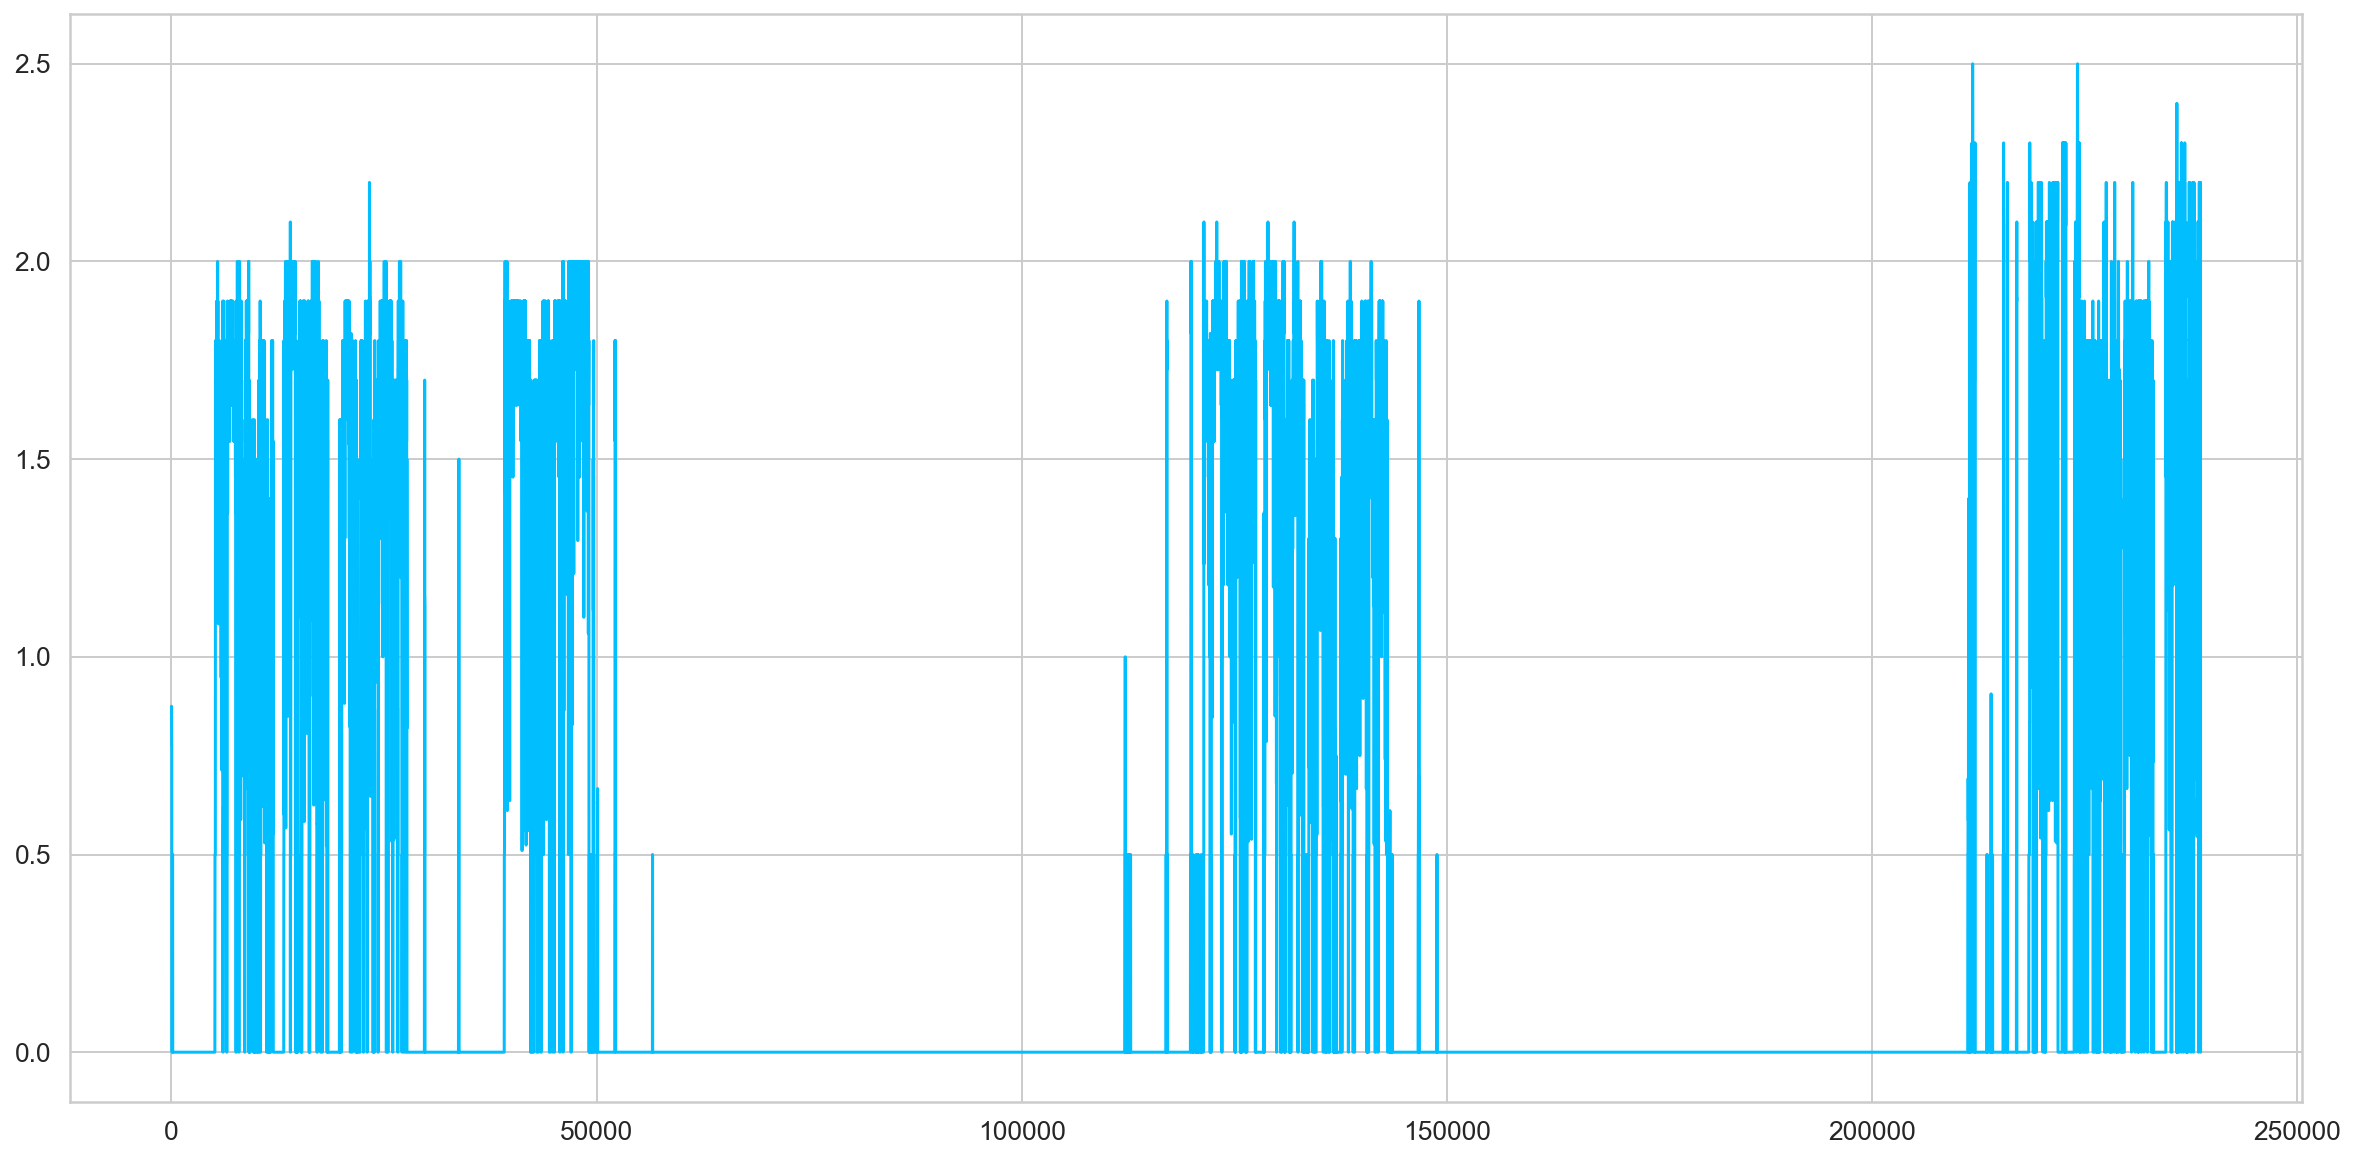

In [7]:
full_df[full_df['Patient']==1000].StepPerSec.plot()

In [8]:
# function that extract from the json weather file for each patient: 
# day, temperature, wind speed, wind direction, rainfall

# this function has also a sort parameter, useful to retrieve hottest/coldest day for further uses

def extracting_daily_counts(df):
    num_days = list(range(1,8))
    non_valid_days = []
    counts = []
    for i,group in df.groupby('Day'):
        counts.append((
                i,
                sum(group['StepPerSec'].values)
                ))
        num_days.remove(int(i[-1]))
    if num_days:
        for d in num_days:
            # we use NaN to deal with missing days from the subject folder
            non_valid_days.append((f'Day{d}', 'NaN'))
            
    return counts+non_valid_days

def extracting_daily_weather(folder, sort=False):
    daily_stats = []
    non_valid_stats = []
    num_days = list(range(1,8))
    for f in os.listdir(folder):
        if f.startswith('weather') and f.endswith('.json'):
            w_file = pd.read_json(os.path.join(folder, f))
            day = f.split('-')[3]
            num_days.remove(int(day[-1]))
            daily_stats.append((day,
                w_file['data'][0]['temp'],
                w_file['data'][0]['wind_speed'],
                w_file['data'][0]['wind_dir'],
                w_file['data'][0]['precip']))
            #format: day, temp, wind speed, wind dir, precip, snow
    if num_days:
        for d in num_days:
            # we use NaN to deal with missing days from the subject folder
            non_valid_stats.append((f'Day{d}', 'NaN', 'NaN', 'NaN', 'NaN'))
    if sort:
        return sorted(daily_stats, key=lambda x: x[1], reverse=True)
    return daily_stats+non_valid_stats

In [9]:
# function that selects and computes the stat on two levels: overall and daily
# stats selected: mean, median, std, max, min, IQR, trimmed mean at 10%

def daily_stats(df, feat, day=None):
    if day is None:
        return np.array([
            [np.mean(df[feat])],
            [np.median(df[feat])],
            [np.std(df[feat])],
            [np.max(df[feat])],
            [np.min(df[feat])],
            [iqr(df[feat])],
            [trim_mean(df[feat], 0.1)]
        ])
    else:
        d_df = df[df['Day']==day]
        return np.array([
            [np.mean(d_df[feat])],
            [np.median(d_df[feat])],
            [np.std(d_df[feat])],
            [np.max(d_df[feat])],
            [np.min(d_df[feat])],
            [iqr(df[feat])],
            [trim_mean(df[feat], 0.1)]
        ])

In [10]:
def create_full_df(folder, df, id, counts):
    step_level = ['StepPerSec', 'StepPerMin']
    stats = ['mean', 'median', 'std', 'max', 'min', 'IQR', 'trim_mean10']
    
    #stats overall aggregate all the daily stats on step per sec and step per mins (cadence) without considering the daily stats
    stats_overall = pd.concat([pd.DataFrame(np.swapaxes(daily_stats(df, s), 0,1), columns=[f'{s}_{i}' for i in stats]) for s in step_level], axis=1)
    #stats daily aggregate all the daily stats on step per sec and step per mins (cadence) on the daily level
    stats_daily = pd.concat([pd.DataFrame(np.swapaxes(daily_stats(df, s, f'Day{j}'), 0,1), columns=[f'Day{j}_{s}_{i}' for i in stats]) for j in range(1,8) for s in step_level], axis=1)

    ds = extracting_daily_weather(folder)
    from_hot_to_cold = extracting_daily_weather(folder, sort=True)

    # we create mnaually a different dataset for weather
    weather_stats = pd.DataFrame(np.swapaxes(np.array(
        [[from_hot_to_cold[0][0]], 
        [from_hot_to_cold[0][1]], 
        [from_hot_to_cold[-1][0]], 
        [from_hot_to_cold[-1][1]]] 
        +[[ds[i][j]] for i in range(7) for j in range(2,5)]
        +[[ds[i][1]] for i in range(7)]), 0,1), 
        
        #columns: hottest day, hottest temp, and coldest ones + daily wind speed, dir and precip
        columns=['hottest_day', 'hottest_temp', 'coldest_day', 'coldest_temp']\
            +[f'Day{i}_wind_speed' for i in range(1,8)]
            +[f'Day{i}_wind_dir' for i in range(1,8)]
            +[f'Day{i}_precip' for i in range(1,8)]
            +[f'Day{i}_temp' for i in range(1,8)]
            )

    final_weath_df = pd.concat([counts, pd.DataFrame([sum(df['StepPerSec'].values)], columns=['NumOfSteps']),\
         pd.DataFrame([id], columns=['ID']), stats_overall, weather_stats, stats_daily], axis=1)

    return final_weath_df

In [16]:
def make_data(thres):
    final_df = pd.DataFrame()
    for id, group in full_df.groupby('Patient'):
        walking = group[group['StepPerSec'] > thres]
        walking.reset_index(inplace=True)
        walking['StepPerMin'] = [el*60 for el in walking['StepPerSec'].values]

        counts = extracting_daily_counts(walking)
        counts_df = pd.DataFrame(np.swapaxes(np.array([[counts[i][1]] for i in range(7)]), 0,1), columns=[f'Day{i}_stepcount' for i in range(1,8)])
        folder = f'mobilised-contextual-factors-v1/{id}'
        
        s_df = create_full_df(folder, walking, id, counts_df)
        final_df = pd.concat([final_df, s_df])
    
    return final_df

In [19]:
final_df_00 = make_data(0)
final_df_00.to_csv('weather_id_00thresh.csv')

final_df_05 = make_data(0.5)
final_df_05.to_csv('weather_id_05thresh.csv')

C:\Users\marci\AppData\Local\Temp\ipykernel_11672\3806279442.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walking['StepPerMin'] = [el*60 for el in walking['StepPerSec'].values]
C:\Users\marci\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\marci\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\marci\AppData\Local\Packages\PythonSoftwareF